# Рекомендательные системы - проект

In [1]:
# Импортируем необходимые библиотеки:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import lightgbm as lgb

import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

import surprise
from surprise import Reader, Dataset


C:\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')

In [197]:
from sklearn.externals import joblib

ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\Anaconda\lib\site-packages\sklearn\externals\__init__.py)

# Загрузка данных

In [ ]:
# чтение json
#with open(Path.cwd() / 'data' / 'meta_Grocery_and_Gourmet_Food.json') as f:
#    bebe = []
#    for line in f.readlines():
#        bebe.append(json.loads(line))

In [3]:
meta = pd.read_csv('Downloads/meta.csv/meta.csv')
meta.head(3)

,Unnamed: 0,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eg...","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'S...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B0...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"['Grocery & Gourmet Food', 'Cooking & Baking',...","['Shipped from UK, please allow 10 to 21 busin...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"['Grocery & Gourmet Food', 'Cooking & Baking',...",['Jazz up your cakes with a sparkling monogram...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",['B07DXN65TF'],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN


In [4]:
# Читаем файлы
train = pd.read_csv('Downloads/recommendationsv4/train.csv')
test = pd.read_csv('Downloads/recommendationsv4/test.csv')
sample_submission = pd.read_csv('Downloads/recommendationsv4/sample_submission.csv')
#tags = pd.read_csv('Downloads/goodbooks-10k/goodbooks/tags.csv')


# EDA train

In [6]:
train.info()
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
overall           857895 non-null float64
verified          857895 non-null bool
reviewTime        857895 non-null object
asin              857895 non-null object
reviewerName      857719 non-null object
reviewText        857616 non-null object
summary           857725 non-null object
unixReviewTime    857895 non-null int64
vote              118740 non-null object
style             444406 non-null object
image             7142 non-null object
userid            857895 non-null int64
itemid            857895 non-null int64
rating            857895 non-null float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0


In [7]:
# Определим процент незаполненных данных в столбцах: удалим столбцы vote, style, image с пропусками более 48%

train.isnull().sum()/857895*100

overall            0.000000
verified           0.000000
reviewTime         0.000000
asin               0.000000
reviewerName       0.020515
reviewText         0.032521
summary            0.019816
unixReviewTime     0.000000
vote              86.159145
style             48.198090
image             99.167497
userid             0.000000
itemid             0.000000
rating             0.000000
dtype: float64

In [5]:
# Удалим столбцы с большим количеством пропусков, дату отзыва (оставим дату в формате unix), 

train = train.drop(['vote', 'style', 'image', 'reviewTime'], axis = 1)

In [9]:
test.info()
test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
verified          285965 non-null bool
reviewTime        285965 non-null object
asin              285965 non-null object
reviewerName      285918 non-null object
unixReviewTime    285965 non-null int64
vote              39462 non-null object
style             147680 non-null object
image             2368 non-null object
userid            285965 non-null int64
itemid            285965 non-null int64
Id                285965 non-null int64
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2


In [10]:
test.isnull().sum()/857895*100

verified           0.000000
reviewTime         0.000000
asin               0.000000
reviewerName       0.005479
unixReviewTime     0.000000
vote              28.733470
style             16.119105
image             33.057309
userid             0.000000
itemid             0.000000
Id                 0.000000
dtype: float64

In [6]:
# Аналогично, удалим на тесте такие же колонки

test = test.drop(['vote', 'style', 'image', 'reviewTime'], axis = 1)

In [ ]:
Видим, что в тренировочном датасете на три столбца больше:

overall - оценка по пятибальной шкале
summary - краткое содержание отзыва
rating - целевая переменная
Создадим копию расширенного датасета df_new, чтобы каждый раз заново не загружать данные, если что-то испортим.

In [7]:
train_copy = train.copy()

In [8]:
# Функция без гистограммы
def col_info(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))

# Функция с гистограммой
def col_info_hist(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))
    ys.hist()

Количество пропусков: 0,
count    857895.000000
mean          4.441695
std           1.064655
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    615196
4.0    113094
3.0     60440
1.0     37498
2.0     31667
Name: overall, dtype: int64,


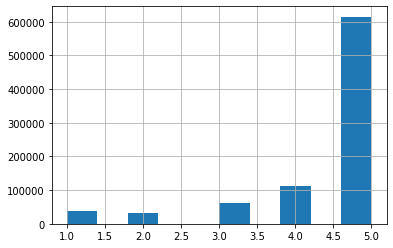

In [9]:
# Overall
col_info_hist(train.overall)
train['overall']=train['overall'].astype('int32')

In [10]:
# verified  Пропусков нет. Заменим значения на бинарные 1 и 0.

col_info(train.verified)
dic_verified = {
    True: 1,
    False: 0
}
train['verified'] = train['verified'].map(dic_verified)

Количество пропусков: 0,
count     857895
unique         2
top         True
freq      745243
Name: verified, dtype: object,
Распределение:
True     745243
False    112652
Name: verified, dtype: int64,


Средняя оценка при значении verified = 1:  4.4803010561655725
Средняя оценка при значении verified = 0:  4.186299399921883


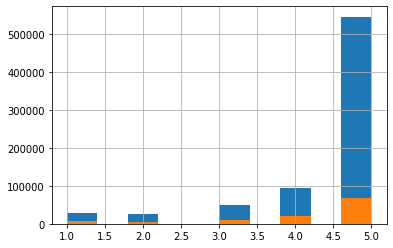

In [11]:
# Посмотрим, как влияет признак verified на среднюю оценку. 
# Видим, что средняя оценка товаров с признаком verified = 1 выше, но в целом распределение оценок похожее.

print('Средняя оценка при значении verified = 1: ',train[train.verified == 1].overall.mean())
train['overall'][train['verified'] == 1].hist(bins=10)
print('Средняя оценка при значении verified = 0: ',train[train.verified == 0].overall.mean())
train['overall'][train['verified'] == 0].hist(bins=10)

In [12]:
# reviewerName
# Видим, что довольно много отзывов с Амазона и Киндла. 180 пропусков. Проверим, один userid у Amazon Customer, или одному имени пользователя может соответствовать несколько userid.
# В таком случае, имя пользователя нам не нужно. Удалим столбец.

col_info(train.reviewerName)
train[train.reviewerName=='Amazon Customer'].userid.value_counts()

Количество пропусков: 176,
count              857719
unique             101207
top       Amazon Customer
freq                31726
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer      31726
Kindle Customer       6228
Linda                  734
John                   725
David                  619
                     ...  
Stephen Guy Hogge        1
JL514                    1
bernie (xyzzy)           1
patricia zambreno        1
Sandra Terry             1
Name: reviewerName, Length: 101207, dtype: int64,


7477      89
1330      56
24035     56
8027      53
15752     48
          ..
62767      1
22369      1
115807     1
3253       1
105430     1
Name: userid, Length: 5329, dtype: int64

In [16]:
train = train.drop(['reviewerName'], axis=1)

[1. 0.]


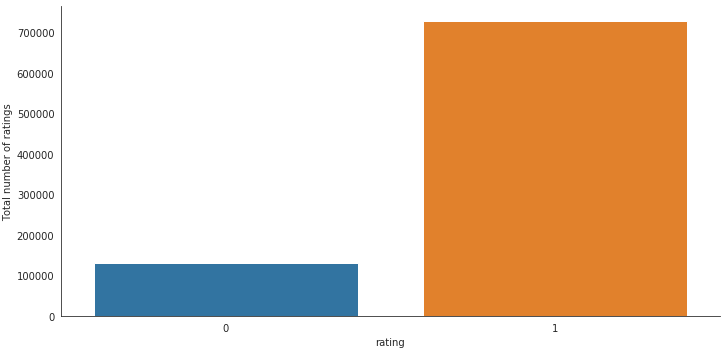

In [13]:
#  rating - бинарная оценка продукта - понравился или нет

print(train['rating'].unique())
train['rating'] = train['rating'].apply(lambda x: int(x))
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

reviewText и summary
Попытка вычленить оценки из текста привела к тем же оценкам, которые уже есть в датасете. Поэтому код ниже можно не выполнять

In [14]:
# Создадим новые признаки оценок пользователя из значений reviewText и summary

words_5 = ['favorite', 'nice', 'great', 'best', 'favorite', 'wonderful', 'love', 'five stars', 'magic', 'perfect','very nice', 'lucky' ]
words_4 = ['good', 'better', 'four stars', 'glad', 'surprised']
words_3 = ['three stars']
words_1 = ['break', "I'd not buy", 'bad', 'one star']
 
train['reviewText'] = train['reviewText'].fillna('no')
train['summary'] = train['summary'].fillna('no')

def rate (desc):
# функция определяет оценку на основании отзыва по реперным словам
    
    desc = desc.lower()
    for w in words_1:
        if w in desc:
            return 1
    for w in words_5:
        if w in desc:
            return 5  
    for w in words_4:
        if w in desc:
            return 4 
        elif  words_3[0] in desc:
            return 3
        else:
            return 2 
    
train['rate_rewiew'] = train['reviewText'].apply(rate)  
print('ok1')
train['rate_summary'] = train['summary'].apply(rate)   
print('ok2')

for i in range(0,len(train)):       # оставим большую из оценок
    train['rate_summary'][i] =  max(train['rate_summary'][i], train['rate_rewiew'][i])
    
display(train['rate_rewiew'].value_counts())
display(train['rate_summary'].value_counts())
train[train.rate_rewiew != train.rate_summary]

ok1
ok2


5    426031
2    272605
4    119935
1     39181
3       143
Name: rate_rewiew, dtype: int64

5    562698
2    180658
4    101289
3      9004
1      4246
Name: rate_summary, dtype: int64

,overall,verified,asin,reviewerName,reviewText,summary,unixReviewTime,userid,itemid,rating,rate_rewiew,rate_summary
2,5,1,B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,39495,5600,1,1,5
3,5,1,B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,72854,30249,1,4,5
5,5,1,B0009F3PM6,indy,"If you are tired of peppermint blends, this is...",best tea ever!!!,1393200000,27865,931,1,2,5
7,5,1,B000WG7M76,JoAnne G..,Thrilled to find sugar free Reese's Peanut But...,Five Stars,1487548800,79155,5034,1,2,5
9,4,0,B0146RYG02,Girlfriend Recommends,I fell in love with the chocolate version of t...,"Tasty, but there's a better version!",1339113600,30070,35087,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
857879,5,1,B00IU1T386,Amazon Customer,I like this brand of ground golden flax seed,Five Stars,1523059200,104299,27844,1,2,5
857880,5,1,B001GM60J6,Shoppingforquality,"Chewy, tasty",Five Stars,1476489600,25131,8589,1,2,5
857886,5,1,B01D5GA2IK,BNorthCovRI,The real deal - excellent quality and taste !,Five Stars,1504483200,2676,37274,1,2,5
857888,5,1,B00E9OWXGW,J. Jolly,Yummy,Five Stars,1433376000,74258,24577,1,2,5


[5 4 2 1 3]
[5. 4. 1. 2. 3.]


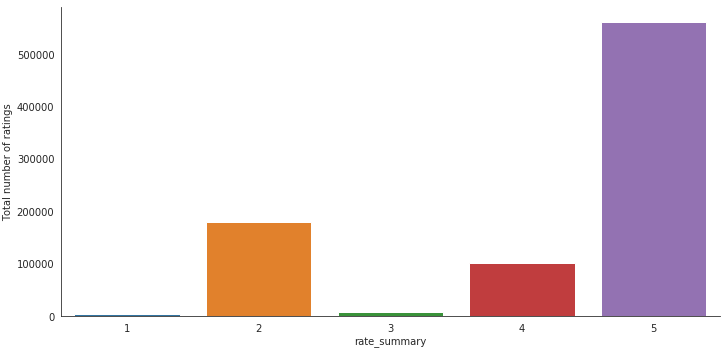

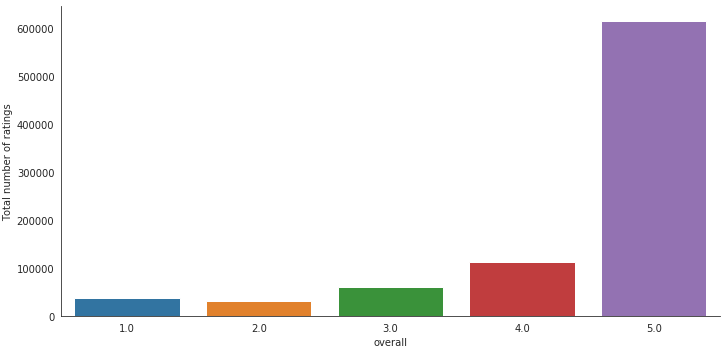

In [89]:
# Сравним диаграммы оценок, определенных из отзывов, и проставленных пользователем.
# Есть различие между распределением оценок1, 2, 3, но в остальном пропорция сохраняется, особенно если делить на 'хорошие' и 'плохие' оценки
# Можно сделать вывод, что поле rating собственно и отражает деление на  'хорошие' и 'плохие' оценки

print(train['rate_summary'].unique())
with sns.axes_style('white'):
    g = sns.factorplot("rate_summary", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
                  
print(train['overall'].unique())
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [15]:
# Удалим столбцы с отзывами 

train = train.drop(['summary', 'reviewText'], axis=1)

In [138]:
# asin идентификатор для модели 

col_info(train.asin)

Количество пропусков: 0,
count         857895
unique         41302
top       B00BUKL666
freq            5491
Name: asin, dtype: object,
Распределение:
B00BUKL666    5491
B00D3M2QP4    4733
B008QMX2SG    4654
B00R7PWK7W    2547
B000X3TPHS    2300
              ... 
B00FKZTBBO       1
B01BB9N9QA       1
B0012QDZBM       1
B005CJUXOM       1
B005TY2FQY       1
Name: asin, Length: 41302, dtype: int64,


Количество пропусков: 0,
count    8.578950e+05
mean     1.441755e+09
std      5.973571e+07
min      9.657792e+08
25%      1.411949e+09
50%      1.449101e+09
75%      1.484870e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    942
1468454400    885
1433289600    799
1453248000    795
1455926400    784
             ... 
1134086400      1
1196812800      1
1184025600      1
1178150400      1
1144454400      1
Name: unixReviewTime, Length: 4580, dtype: int64,


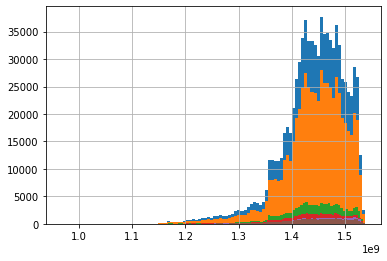

In [16]:
# unixReviewTime  Пропусков нет. Посмотрим, как изменялись оценки со временем.

col_info(train.unixReviewTime)
train.unixReviewTime.hist(bins=100)
train[train.overall == 5].unixReviewTime.hist(bins=100)
train[train.overall == 4].unixReviewTime.hist(bins=100)
train[train.overall == 3].unixReviewTime.hist(bins=100)
train[train.overall == 1].unixReviewTime.hist(bins=100)
train[train.overall == 2].unixReviewTime.hist(bins=100)

In [17]:
from datetime import datetime
tsmin = train.unixReviewTime.min()
ts25 = int(train.unixReviewTime.quantile(0.25))
ts50 = int(train.unixReviewTime.quantile(0.50))
ts75 = int(train.unixReviewTime.quantile(0.75))
tsmax = train.unixReviewTime.max()
print('Самый первый отзыв:', datetime.utcfromtimestamp(tsmin).strftime('%Y-%m-%d %H:%M:%S'))
print('25 квантиль:', datetime.utcfromtimestamp(ts25).strftime('%Y-%m-%d %H:%M:%S'))
print('50 квантиль:', datetime.utcfromtimestamp(ts50).strftime('%Y-%m-%d %H:%M:%S'))
print('75 квантиль:', datetime.utcfromtimestamp(ts75).strftime('%Y-%m-%d %H:%M:%S'))
print('Последний отзыв:', datetime.utcfromtimestamp(tsmax).strftime('%Y-%m-%d %H:%M:%S'))

Самый первый отзыв: 2000-08-09 00:00:00
25 квантиль: 2014-09-29 00:00:00
50 квантиль: 2015-12-03 00:00:00
75 квантиль: 2017-01-20 00:00:00
Последний отзыв: 2018-10-02 00:00:00


In [18]:
# Создадим 4 категории в зависимости от даты написания
def cat_date(x):
    if x <= ts25: x = 4
    elif ts25 < x <= ts50: x = 3
    elif ts50 < x <= ts75: x = 2
    elif ts75 < x: x = 1
    return x      

# Заменим значения в столбце на категории
train['unixReviewTime'] = train['unixReviewTime'].apply(lambda x: cat_date(x))

In [19]:
train = train.drop(['overall', 'verified'], axis = 1) # 781124 - >> 777688 

In [20]:
# Удалим дубликаты

train = train.drop_duplicates(keep=False, inplace=False)

In [21]:
train

,asin,reviewerName,unixReviewTime,userid,itemid,rating,rate_rewiew,rate_summary
0,B01CPNIEQG,Heather,2,102179,37138,1,5,5
1,B006F63M8U,Linda Odom,2,3625,17322,1,4,4
2,B00112O8NG,DesertBlossom,2,39495,5600,1,1,5
3,B00MRAQUM8,Connie L. Reaves,4,72854,30249,1,4,5
4,B000R7RN0G,Mike P.,2,74859,4349,1,5,5
...,...,...,...,...,...,...,...,...
857888,B00E9OWXGW,J. Jolly,3,74258,24577,1,2,5
857889,B008QMX2SG,B. M. C,2,70292,24556,1,4,4
857892,B000LKX6R8,bamboo grove,2,88,3251,1,1,4
857893,B00BUKL666,Speedway91,3,41540,22208,1,5,5


# EDA test

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 7 columns):
verified          285965 non-null bool
asin              285965 non-null object
reviewerName      285918 non-null object
unixReviewTime    285965 non-null int64
userid            285965 non-null int64
itemid            285965 non-null int64
Id                285965 non-null int64
dtypes: bool(1), int64(4), object(2)
memory usage: 13.4+ MB


In [25]:
test.Id.unique()

array([     0,      1,      2, ..., 285962, 285963, 285964], dtype=int64)

In [22]:
# Удалим reviewerName как и в train, и Id как дублирующий

test = test.drop(['reviewerName', 'Id'], axis = 1)

In [27]:
test[test.asin == 'B000A7Q2J6']

,verified,asin,unixReviewTime,userid,itemid


In [29]:
test.isnull().sum()/857895*100

verified          0.0
asin              0.0
unixReviewTime    0.0
userid            0.0
itemid            0.0
dtype: float64

In [23]:
test['verified'] = test['verified'].apply(lambda x: 1 if True else 0)

# EDA meta

In [31]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 18 columns):
Unnamed: 0      287209 non-null int64
category        287209 non-null object
description     251802 non-null object
title           287205 non-null object
brand           275766 non-null object
rank            275494 non-null object
also_view       121012 non-null object
main_cat        285716 non-null object
price           132136 non-null object
asin            287209 non-null object
also_buy        83332 non-null object
image           150214 non-null object
date            9663 non-null object
feature         16374 non-null object
details         273323 non-null object
similar_item    256 non-null object
tech1           744 non-null object
fit             4 non-null object
dtypes: int64(1), object(17)
memory usage: 39.4+ MB


In [32]:
meta.isnull().sum()/857895*100

Unnamed: 0       0.000000
category         0.000000
description      4.127195
title            0.000466
brand            1.333846
rank             1.365552
also_view       19.372650
main_cat         0.174031
price           18.075988
asin             0.000000
also_buy        23.764796
image           15.968737
date            32.351978
feature         31.569714
details          1.618613
similar_item    33.448499
tech1           33.391616
fit             33.477873
dtype: float64

In [24]:
# ВСе нижеприведенные столбцы проверены на уникальность и содержание, а также на количество пропусков. Принято решение - удалить их.

meta = meta.drop(['fit', 'tech1', 'similar_item', 'image', 'date', 'feature', 'details', 'description', 'title', 'Unnamed: 0'], axis = 1)

In [34]:
meta.isnull().sum()/857895*100

category      0.000000
brand         1.333846
rank          1.365552
also_view    19.372650
main_cat      0.174031
price        18.075988
asin          0.000000
also_buy     23.764796
dtype: float64

In [25]:
# Объединим 

train2 = train.merge(meta, on='asin', how='left')
train2[:5]

,asin,reviewerName,unixReviewTime,userid,itemid,rating,rate_rewiew,rate_summary,category,brand,rank,also_view,main_cat,price,also_buy
0,B01CPNIEQG,Heather,2,102179,37138,1,5,5,"['Grocery & Gourmet Food', 'Herbs, Spices & Se...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","['B00AJRKRJS', 'B01NALHAY9', 'B01DGZ2B48', 'B0...",Grocery,$9.95,"['B01DGZ2B48', 'B01EZ489AO', 'B01DH795LM', 'B0..."
1,B006F63M8U,Linda Odom,2,3625,17322,1,4,4,"['Grocery & Gourmet Food', 'Beverages', 'Coffe...",Swiss Miss,"5,591inGroceryGourmetFood(",NaN,Grocery,$18.49,"['B001FBKO4U', 'B00BJ9URYA', 'B00451ZJB0', 'B0..."
2,B00112O8NG,DesertBlossom,2,39495,5600,1,1,5,"['Grocery & Gourmet Food', 'Beverages', 'Bottl...",Torani,NaN,"['B006K3UC86', 'B000WGB3OY']",Grocery,NaN,"['B000T9WLUY', 'B01K23RF7U', 'B0015GSBUY', 'B0..."
3,B00MRAQUM8,Connie L. Reaves,4,72854,30249,1,4,5,"['Grocery & Gourmet Food', 'Herbs, Spices & Se...",Frontier,"168,917inGroceryGourmetFood(",NaN,Grocery,$44.95,"['B00416T7E4', 'B0001M11DC', 'B001VNO1NM', 'B0..."
4,B000R7RN0G,Mike P.,2,74859,4349,1,5,5,"['Grocery & Gourmet Food', 'Snack Foods', 'Chi...",Miss Vickie's,"61,690inGroceryGourmetFood(","['B006WYSG6S', 'B00F0C0S2I', 'B00CWYM3OI', 'B0...",Grocery,NaN,"['B000R7XBF2', 'B000HIFA8W', 'B000R7RODW', 'B0..."


In [37]:
train2.isnull().sum()/857895*100

asin               0.000000
unixReviewTime     0.000000
userid             0.000000
itemid             0.000000
rating             0.000000
category           0.000000
brand              0.674791
rank               3.622238
also_view         43.272895
main_cat           0.107472
price             28.189231
also_buy          13.482419
dtype: float64

# category и main_cat
Заполним пропущенные значения главной категории первым значением их списка категорий, удалим столбец со списком всех категорий

In [26]:
train2['main_cat'] = train2['main_cat'].fillna(train2['category'].apply(lambda x: x.split(',')[0]))

In [27]:
def category (cat):
    if cat == "['Grocery & Gourmet Food'":
        return 'Grocery'
    else:
        return cat

In [28]:
train2['main_cat'] = train2['main_cat'].apply(category)

In [29]:
train2 = train2.drop(['category'], axis=1)
train2['main_cat'].unique()


array(['Grocery', 'Health & Personal Care', 'Office Products',
       'Sports & Outdoors', 'Amazon Home', 'Toys & Games',
       'Industrial & Scientific', 'All Beauty',
       'Tools & Home Improvement', 'Baby', 'Pet Supplies',
       'Home Audio & Theater', 'Arts, Crafts & Sewing', 'Camera & Photo',
       'Cell Phones & Accessories', 'Software', 'Musical Instruments'],
      dtype=object)

In [43]:
# also_buy. Заполним пустые значения значениями also_view

train2['also_buy'] = train2['also_buy'].fillna(train2['also_view'])

In [44]:
train2['also_buy'] = train2['also_buy'].fillna(train2['rank'].apply(lambda x: str(x).split(',')[0]))

In [45]:
train2['also_buy'] = train2['also_buy'].apply(lambda x: str(x).replace('>#',''))

In [46]:
def asin (asin_list):
   # id_list = []
    asin_list = asin_list.split(',')
    if len(asin_list)==1:
        id_list.append(asin_list)


In [47]:
id_list = []
train2['also_buy'].apply(asin)

0         None
1         None
2         None
3         None
4         None
          ... 
795143    None
795144    None
795145    None
795146    None
795147    None
Name: also_buy, Length: 795148, dtype: object

In [520]:
id_list.sort()
id_list

[['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],


In [30]:
# устала бороться с заполнением, удаляем столбцы

train3 = train2.drop(['rank', 'also_view', 'also_buy', 'asin'], axis=1)

In [49]:
train3

,unixReviewTime,userid,itemid,rating,brand,main_cat,price
0,2,102179,37138,1.0,Primal Palate Organic Spices,Grocery,$9.95
1,2,3625,17322,1.0,Swiss Miss,Grocery,$18.49
2,2,39495,5600,1.0,Torani,Grocery,NaN
3,4,72854,30249,1.0,Frontier,Grocery,$44.95
4,2,74859,4349,1.0,Miss Vickie's,Grocery,NaN
...,...,...,...,...,...,...,...
795143,3,74258,24577,1.0,Nongshim,Grocery,NaN
795144,2,70292,24556,1.0,KIND,Grocery,$14.79
795145,2,88,3251,1.0,Hakubaku,Grocery,$22.45
795146,3,41540,22208,1.0,KIND,Grocery,$13.67


In [50]:
train3['brand'].value_counts()

KIND                              20743
Bob's Red Mill                    11624
Twinings                           9988
Planters                           9849
Green Mountain Coffee Roasters     6609
                                  ...  
EASTSHORE                             1
Coolest Bear                          1
DELICITALY Pure Italian Food          1
cocomama                              1
Seaweed                               1
Name: brand, Length: 8846, dtype: int64

In [31]:
# Нулевые значения brand заполним самым популярным
train3['brand'] = train3['brand'].fillna('KIND')

In [32]:
# Приведем цену к целому среднему значению и уберем мусор.

from collections import Counter
import json
import re
# Скопируем датасет
df_price = train3.copy()
# Избавимся от пропусков
df_price = df_price[df_price.price.isna() == False]
df_price = df_price[df_price.price != '']
# Приведем все к str
df_price['price'] = df_price['price'].astype('str')
# Удалим все значения кроме числовых
df_price['price'] = df_price['price'].apply(lambda x: re.sub('\D', '', x))
# Переведем во float
df_price['price'] = df_price['price'].astype('float')
# Удалим все, что дороже 9999$ т.к. это, скорее всего, ошибка
df_price = df_price[df_price.price < 999999]


df_price_mean = df_price.price.mean()
# Приведем все к str
train3['price'] = train3['price'].astype('str')
# Удалим все значения кроме числовых
train3['price'] = train3['price'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на среднее значение
train3['price'] = train3['price'].apply(lambda x: round(df_price_mean, 0) if x == '' else x)
# Приведем к float
train3['price'] = train3['price'].astype('float')
# Заменим большие значения на средние
train3['price'] = train3['price'].apply(lambda x: round(df_price_mean, 0) if x > 999999 else x)
# Приведем к int32
train3['price'] = train3['price'].astype('int32')

In [53]:
train3

,unixReviewTime,userid,itemid,rating,brand,main_cat,price
0,2,102179,37138,1.0,Primal Palate Organic Spices,Grocery,995
1,2,3625,17322,1.0,Swiss Miss,Grocery,1849
2,2,39495,5600,1.0,Torani,Grocery,2075
3,4,72854,30249,1.0,Frontier,Grocery,4495
4,2,74859,4349,1.0,Miss Vickie's,Grocery,2075
...,...,...,...,...,...,...,...
795143,3,74258,24577,1.0,Nongshim,Grocery,2075
795144,2,70292,24556,1.0,KIND,Grocery,1479
795145,2,88,3251,1.0,Hakubaku,Grocery,2245
795146,3,41540,22208,1.0,KIND,Grocery,1367


In [33]:
train3 = train3.drop_duplicates(keep=False, inplace=False)
train3

,reviewerName,unixReviewTime,userid,itemid,rating,rate_rewiew,rate_summary,brand,main_cat,price
0,Heather,2,102179,37138,1,5,5,Primal Palate Organic Spices,Grocery,995
1,Linda Odom,2,3625,17322,1,4,4,Swiss Miss,Grocery,1849
2,DesertBlossom,2,39495,5600,1,1,5,Torani,Grocery,2075
3,Connie L. Reaves,4,72854,30249,1,4,5,Frontier,Grocery,4495
4,Mike P.,2,74859,4349,1,5,5,Miss Vickie's,Grocery,2075
...,...,...,...,...,...,...,...,...,...,...
802868,J. Jolly,3,74258,24577,1,2,5,Nongshim,Grocery,2075
802869,B. M. C,2,70292,24556,1,4,4,KIND,Grocery,1479
802870,bamboo grove,2,88,3251,1,1,4,Hakubaku,Grocery,2245
802871,Speedway91,3,41540,22208,1,5,5,KIND,Grocery,1367


# Reader колабративная фильтрация методом ближайших соседей

In [ ]:
# Результат этого алгоритма на кагл не впечатляет  = 0.6

import surprise
from surprise import Reader, Dataset

In [542]:
user_sample = train3.userid.sample(len(train3.userid.unique()))  
item_sample = train3.itemid.sample(len(train3.itemid.unique()))

In [548]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train3[train3.userid.isin(user_sample) &
                              train3.itemid.isin(item_sample)][['userid', 'itemid', 'rating']], reader)

In [549]:
from surprise import KNNBasic

sim_options = {
    'name': 'cosine',
    'user_based': False
}
 
knn = KNNBasic(sim_options=sim_options)

In [550]:
trainingSet = data.build_full_trainset()

In [573]:
model = knn.fit(trainingSet)

Computing the cosine similarity matrix...


MemoryError: 

In [552]:
test['rating'] = 0
test

,verified,asin,unixReviewTime,userid,itemid,rating
0,1,B001E5E3X0,1475280000,68877,7506,0
1,1,B005BYXX5E,1404000000,50442,15530,0
2,1,B0052OK6OO,1431993600,64349,15049,0
3,1,B003SO8HGE,1412467200,26206,11957,0
4,1,B003XUJ564,1384128000,59366,12173,0
...,...,...,...,...,...,...
285960,1,B00FLD3X28,1452988800,294,25601,0
285961,1,B0078DQ85S,1440201600,119653,18204,0
285962,1,B000FZVLFS,1505952000,54673,2287,0
285963,1,B001PB801Y,1522108800,16569,9343,0


In [553]:
test2 = Dataset.load_from_df(test[['userid', 'itemid', 'rating']], reader)

In [21]:
testSet = test2.construct_testset(test2.raw_ratings)

In [22]:
predictions2 = knn.test(testSet)
predictions2

[Prediction(uid=68877, iid=7506, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=50442, iid=15530, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=64349, iid=15049, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=26206, iid=11957, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=59366, iid=12173, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2467, iid=13076, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=49329, iid=26418, r_ui=0.0, est=5.0, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=25316, iid=5734, r_

In [32]:
sample_submission['rating']=[pred.est for pred in predictions2]

In [33]:
sample_submission.to_csv('rec_submission_6.csv', index=False)

# SVD

In [ ]:
# Результат этого алгоритма на кагл тоже не особо  = 0.70282

In [556]:
user_sample = train.userid.sample(127024)
item_sample = train.itemid.sample(41247)

In [557]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train3[train3.userid.isin(user_sample) &
                              train3.itemid.isin(item_sample)][['userid', 'itemid', 'rating']], reader)

In [558]:
from surprise import SVD

In [559]:
svd=SVD()
trainingSet=data.build_full_trainset()

In [560]:
test['rating'] = 0

In [561]:
data_test = Dataset.load_from_df(test[['userid', 'itemid', 'rating']], reader)

In [562]:
svd.fit(trainingSet)

In [563]:
testSet = data_test.construct_testset(data_test.raw_ratings)

In [568]:
#testSet=test.build_full_trainset()
predictions3 = svd.test(testSet)
predictions3

[Prediction(uid=68877, iid=7506, r_ui=0.0, est=0.8798875710915888, details={'was_impossible': False}),
 Prediction(uid=50442, iid=15530, r_ui=0.0, est=0.8782868388719244, details={'was_impossible': False}),
 Prediction(uid=64349, iid=15049, r_ui=0.0, est=0.8655761643058448, details={'was_impossible': False}),
 Prediction(uid=26206, iid=11957, r_ui=0.0, est=0.8508713042991805, details={'was_impossible': False}),
 Prediction(uid=59366, iid=12173, r_ui=0.0, est=0.8285189473958966, details={'was_impossible': False}),
 Prediction(uid=2467, iid=13076, r_ui=0.0, est=0.9048269561275597, details={'was_impossible': False}),
 Prediction(uid=49329, iid=26418, r_ui=0.0, est=0.8230370258601761, details={'was_impossible': False}),
 Prediction(uid=25316, iid=5734, r_ui=0.0, est=0.9193455893747676, details={'was_impossible': False}),
 Prediction(uid=108256, iid=28914, r_ui=0.0, est=0.7209288634225844, details={'was_impossible': False}),
 Prediction(uid=20220, iid=3050, r_ui=0.0, est=0.6709669475778491,

In [569]:
sample_submission['rating']=[pred.est for pred in predictions3]

In [212]:
#normalized_preds = (sample_submission['rating'] - sample_submission['rating'].min())/(sample_submission['rating'] - sample_submission['rating'].min()).max()

In [570]:
#sample_submission['rating']=normalized_preds
sample_submission['rating'].unique()

array([0.87988757, 0.87828684, 0.86557616, ..., 0.58106197, 0.75708438,
       0.98823264])

In [571]:
sample_submission.to_csv('rec_submission_11.csv', index=False)

In [566]:
train3.main_cat.unique()

array([ 1,  3,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [565]:
dic_cat = {
    'Grocery': 1, 
    'Health & Personal Care': 2, 
    'Office Products':3,
    'Sports & Outdoors':4, 
    'Amazon Home':4, 
    'Toys & Games':5,
    'Industrial & Scientific':6, 
    'All Beauty':7,
    'Tools & Home Improvement':8, 
    'Baby':9, 
    'Pet Supplies':10,
    'Home Audio & Theater':11, 
    'Arts, Crafts & Sewing':12, 
    'Camera & Photo':13,
    'Cell Phones & Accessories': 14, 
    'Software':15, 
    'Musical Instruments':16
}

train3['main_cat'] = train3['main_cat'].map(dic_cat)

In [567]:
train3.brand.unique()

array(['Primal Palate Organic Spices', 'Swiss Miss', 'Torani', ...,
       'Peanut Butter Americano', 'Barefoot Contessa Pantry',
       'Genesis Today'], dtype=object)

# LIGHTFM без фич

In [184]:
#число потоков нашего процессора
NUM_THREADS = 8

#число параметров вектора 
NUM_COMPONENTS = 180 

#число эпох обучения
NUM_EPOCHS = 20 

In [80]:
#Создаём модель
#model = LightFM(learning_rate=0.05, loss='warp', no_components=NUM_COMPONENTS)


In [163]:
 
#Разбиваем наш датасет на обучающую и тестовую выборки
#trainy,testy = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=32)
train_data, test_data = train_test_split(train3,random_state=32, shuffle=True)

In [164]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

# ratings_coo = sparse.coo_matrix((train2.overall,(train2.userid,train2.itemid)))

In [185]:
# без фич

model = LightFM(learning_rate=0.2, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [95]:
from scipy.sparse import coo_matrix, hstack
A = coo_matrix([[1, 2], [3, 4]])
B = coo_matrix([[5], [6]])
hstack([A,B]).toarray()

array([[1, 2, 5],
       [3, 4, 6]], dtype=int32)

In [82]:
#Обучаем модель
#model = model.fit(trainy, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,item_features =feature_ratings)

In [ ]:
#0.7297085731514241 - 0.07, 0.7299 - 0.1,  0.7272- cat в цифры, 0.6206 - 0.001, 0.662386378 - 0.01, 0.7088803176 -0.13
# 0.71272 - 80, 0.7103960588 - 60, 0.7139- 180

In [186]:
predst = model.predict(test_data.userid.values,
                      test_data.itemid.values)
sklearn.metrics.roc_auc_score(test_data.rating, predst)

0.7139292237827657

In [52]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

In [55]:
print(preds.min(), preds.max())


-2.1322097778320312 4.268839359283447


In [54]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [56]:
print(normalized_preds.min(), normalized_preds.max())

0.0 1.0


In [57]:
sample_submission['rating']= normalized_preds
sample_submission.to_csv('rec_submission_9.csv', index=False)

In [109]:
dic_test = dict(zip((test['userid']), (test['itemid'])))

In [110]:
dic_train = dict(zip((train3['userid']), (train3['itemid'])))

In [113]:
value = set(dic_test)-set(dic_train)
print (value)

{104451, 106510, 90131, 69670, 24615, 4147, 81971, 108603, 88139, 8269, 84045, 90195, 90198, 45143, 88151, 90200, 90202, 53339, 106590, 79973, 79977, 2154, 4207, 84086, 86136, 16505, 88188, 73857, 88193, 84099, 116866, 116867, 4232, 10376, 80015, 73874, 86162, 88221, 80039, 88232, 88239, 86193, 16564, 43188, 84151, 88285, 114911, 16617, 127212, 127217, 114931, 127220, 127221, 90359, 10488, 88315, 82180, 10501, 80150, 90390, 8472, 14623, 84259, 84261, 16682, 88369, 26930, 90418, 117048, 127289, 28988, 49473, 14667, 78157, 12623, 121170, 14681, 127327, 86370, 45411, 12646, 29031, 121193, 20842, 121194, 127340, 80238, 123250, 94579, 80254, 127361, 80262, 29066, 37265, 90514, 70039, 82328, 29086, 86437, 119206, 82355, 74166, 55737, 70080, 65986, 29129, 29130, 90571, 90572, 90576, 82385, 90579, 90581, 2523, 20959, 86497, 10725, 27110, 111078, 29167, 14832, 47605, 88569, 96768, 27162, 84510, 88609, 88610, 88616, 84522, 88622, 125488, 82482, 90679, 8767, 90687, 100928, 119359, 119360, 23108, 

# LIGHTGBM алгоритм  

Итог на кагл: 0.52892

In [67]:
train_data_GB = pd.DataFrame({
    'userid': train3['userid'],
    'itemid': train3['itemid'],
    'rating': train3['rating']
})

test_data_GB = pd.DataFrame({
    'userid': test['userid'],
    'itemid': test['itemid'],
})

In [81]:
train_data_GB_train, test_data_GB_test = train_test_split(train_data_GB,random_state=13, shuffle=True)

In [82]:
y_train = train_data_GB_train['rating']
y_test = test_data_GB_test['rating']
X_train = train_data_GB_train.drop('rating', axis=1)
X_test = test_data_GB_test.drop('rating', axis=1)

In [68]:
# Полная обучающая выборка без деления на тестовую.
y_train = train_data_GB['rating']
y_test = train_data_GB['rating']
X_train = train_data_GB.drop('rating', axis=1)
X_test = train_data_GB.drop('rating', axis=1)

In [95]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
   # 'objective': 'binary',
   # 'metric': {'l2', 'l1'},
    'num_leaves': 34,
    'learning_rate': 0.1,
    'metric': 'binary_logloss',
    'feature_fraction': 0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')

Starting training...


In [96]:
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=40,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)
print('Starting predicting...')


[1]	valid_0's binary_logloss: 0.428729
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.428571
[3]	valid_0's binary_logloss: 0.428444
[4]	valid_0's binary_logloss: 0.428346
[5]	valid_0's binary_logloss: 0.428254
[6]	valid_0's binary_logloss: 0.428168
[7]	valid_0's binary_logloss: 0.42808
[8]	valid_0's binary_logloss: 0.427999
[9]	valid_0's binary_logloss: 0.427937
[10]	valid_0's binary_logloss: 0.427888
[11]	valid_0's binary_logloss: 0.427851
[12]	valid_0's binary_logloss: 0.42781
[13]	valid_0's binary_logloss: 0.427788
[14]	valid_0's binary_logloss: 0.42777
[15]	valid_0's binary_logloss: 0.427746
[16]	valid_0's binary_logloss: 0.427719
[17]	valid_0's binary_logloss: 0.427699
[18]	valid_0's binary_logloss: 0.427678
[19]	valid_0's binary_logloss: 0.427662
[20]	valid_0's binary_logloss: 0.427639
[21]	valid_0's binary_logloss: 0.427611
[22]	valid_0's binary_logloss: 0.427598
[23]	valid_0's binary_logloss: 0.427586
[24]	valid_0's binary_logloss: 

In [97]:
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred

array([0.83068198, 0.83385718, 0.83504239, ..., 0.85172902, 0.85585335,
       0.8383738 ])

In [71]:
preds =  gbm.predict(test_data_GB, num_iteration=gbm.best_iteration)

In [73]:
preds.min()

0.8244436507731701

In [98]:
sklearn.metrics.roc_auc_score(y_test, y_pred)

0.5441062523247172

In [74]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [76]:
normalized_preds.min()

0.0

In [78]:
sample_submission['rating'] = normalized_preds
sample_submission.to_csv('rec_submission_12.csv', index=False)
sample_submission.head(3)

,Id,rating
0,0,0.533679
1,1,0.362722
2,2,0.391188


# LIGHTFM с фичами

In [128]:
#число потоков нашего процессора
NUM_THREADS = 8

#число параметров вектора 
NUM_COMPONENTS = 130 

#число эпох обучения
NUM_EPOCHS = 14 

In [129]:
#Разбиваем наш датасет на обучающую и тестовую выборки
#trainy,testy = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=32)
train_data, test_data = train_test_split(train3,random_state=42, shuffle=True)

In [130]:
train3.head(3)

,reviewerName,unixReviewTime,userid,itemid,rating,rate_rewiew,rate_summary,brand,main_cat,price
0,Heather,2,102179,37138,1,5,5,Primal Palate Organic Spices,Grocery,995
1,Linda Odom,2,3625,17322,1,4,4,Swiss Miss,Grocery,1849
2,DesertBlossom,2,39495,5600,1,1,5,Torani,Grocery,2075


In [131]:
from lightfm.data import Dataset

In [132]:
dataset1 = Dataset()

In [137]:

features_user = train3[['userid', 'unixReviewTime']]
features_item = train3[['itemid','main_cat', 'price']]
df = train3[['userid','itemid','rating']]

In [138]:
item_f = []
col = []
unique_f1 = []
for column in features_item.drop(['itemid'], axis=1):
    col += [column]*len(features_item[column].unique())
    unique_f1 += list(features_item[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    item_f.append(res)
    print(res)

main_cat:Grocery
main_cat:Health & Personal Care
main_cat:Office Products
main_cat:Sports & Outdoors
main_cat:Amazon Home
main_cat:Toys & Games
main_cat:Industrial & Scientific
main_cat:All Beauty
main_cat:Tools & Home Improvement
main_cat:Baby
main_cat:Pet Supplies
main_cat:Home Audio & Theater
main_cat:Arts, Crafts & Sewing
main_cat:Camera & Photo
main_cat:Cell Phones & Accessories
main_cat:Software
main_cat:Musical Instruments
price:995
price:1849
price:2075
price:4495
price:2394
price:2610
price:649
price:1577
price:2479
price:371
price:1195
price:2803
price:3455
price:1945
price:2088
price:1947
price:2370
price:666
price:1299
price:2312
price:766
price:1527
price:1850
price:1188
price:2799
price:1395
price:1845
price:1367
price:1576
price:3797
price:4339
price:1698
price:1464
price:1840
price:3443
price:1799
price:3985
price:2898
price:1879
price:1346
price:2495
price:922
price:2505
price:2219
price:1200
price:1549
price:1499
price:1697
price:2952
price:1640
price:2580
price:2468


price:1307
price:2335
price:906
price:1921
price:2852
price:1722
price:3059
price:1863
price:3036
price:1120
price:1364
price:884
price:7586
price:2719
price:871
price:818
price:2102
price:3544
price:942
price:2010
price:2647
price:662
price:322
price:1034
price:3988
price:2734
price:2441
price:2258
price:3311
price:5220
price:610
price:1312
price:1694
price:2621
price:2008
price:2709
price:1235
price:1933
price:1967
price:3969
price:1818
price:2215
price:1070
price:819
price:1008
price:2117
price:1138
price:1852
price:3700
price:1410
price:2851
price:3321
price:6697
price:586
price:2593
price:3858
price:1521
price:1467
price:3111
price:2279
price:3318
price:4776
price:1037
price:2137
price:3973
price:4750
price:2631
price:516
price:3583
price:4166
price:2264
price:2325
price:2592
price:396
price:1702
price:1042
price:953
price:1078
price:4654
price:1571
price:5783
price:413
price:1719
price:1278
price:5274
price:301
price:514
price:3325
price:4428
price:1193
price:2222
price:4925
pric

price:8195
price:3521
price:1511
price:4775
price:3674
price:3870
price:4186
price:3407
price:1964
price:2504
price:4502
price:2676
price:6180
price:10432
price:2434
price:4678
price:4732
price:5219
price:3032
price:4847
price:4398
price:1827
price:747
price:3614
price:3876
price:4060
price:4152
price:4655
price:6519
price:3212
price:4162
price:260
price:2202
price:3025
price:3677
price:207
price:3065
price:5090
price:4178
price:4592
price:1911
price:7420
price:7446
price:3454
price:3781
price:9689
price:3162
price:4896
price:1471
price:2712
price:2304
price:7608
price:6622
price:1941
price:2233
price:5467
price:4686
price:213
price:97
price:129
price:4672
price:4135
price:7642
price:3970
price:8500
price:3941
price:4573
price:6069
price:492
price:6488
price:7070
price:5929
price:3931
price:4386
price:7706
price:1153
price:7840
price:7598
price:2041
price:1413
price:3161
price:3832
price:4414
price:45
price:1931
price:1737
price:8656
price:1868
price:2512
price:5029
price:5247
price:43

In [139]:

user_f = []
col = []
unique_f1 = []
for column in features_user.drop(['userid'], axis=1):
    col += [column]*len(features_user[column].unique())
    unique_f1 += list(features_user[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    user_f.append(res)
    print(res)

unixReviewTime:2
unixReviewTime:4
unixReviewTime:1
unixReviewTime:3


In [133]:
# удалить
uf = []
col = ['unixReviewTime']*len(train3.unixReviewTime.unique()) + ['main_cat']*len(train3.main_cat.unique()) + ['price']*len(train3['price'].unique())
unique_f1 = list(train3.unixReviewTime.unique()) + list(train3.main_cat.unique()) + list(train3['price'].unique())
#print('f1:', unique_f1)
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    uf.append(res)
    print(res)

unixReviewTime:2
unixReviewTime:4
unixReviewTime:1
unixReviewTime:3
main_cat:Grocery
main_cat:Health & Personal Care
main_cat:Office Products
main_cat:Sports & Outdoors
main_cat:Amazon Home
main_cat:Toys & Games
main_cat:Industrial & Scientific
main_cat:All Beauty
main_cat:Tools & Home Improvement
main_cat:Baby
main_cat:Pet Supplies
main_cat:Home Audio & Theater
main_cat:Arts, Crafts & Sewing
main_cat:Camera & Photo
main_cat:Cell Phones & Accessories
main_cat:Software
main_cat:Musical Instruments
price:995
price:1849
price:2075
price:4495
price:2394
price:2610
price:649
price:1577
price:2479
price:371
price:1195
price:2803
price:3455
price:1945
price:2088
price:1947
price:2370
price:666
price:1299
price:2312
price:766
price:1527
price:1850
price:1188
price:2799
price:1395
price:1845
price:1367
price:1576
price:3797
price:4339
price:1698
price:1464
price:1840
price:3443
price:1799
price:3985
price:2898
price:1879
price:1346
price:2495
price:922
price:2505
price:2219
price:1200
price:154

price:1144
price:3098
price:661
price:1954
price:4789
price:3631
price:2034
price:4394
price:1547
price:1088
price:2424
price:2131
price:529
price:867
price:4895
price:3053
price:5994
price:4766
price:1536
price:3168
price:2186
price:438
price:2987
price:9675
price:1265
price:835
price:1082
price:2206
price:2048
price:1006
price:3605
price:1526
price:2392
price:2012
price:1692
price:525
price:3926
price:1844
price:1307
price:2335
price:906
price:1921
price:2852
price:1722
price:3059
price:1863
price:3036
price:1120
price:1364
price:884
price:7586
price:2719
price:871
price:818
price:2102
price:3544
price:942
price:2010
price:2647
price:662
price:322
price:1034
price:3988
price:2734
price:2441
price:2258
price:3311
price:5220
price:610
price:1312
price:1694
price:2621
price:2008
price:2709
price:1235
price:1933
price:1967
price:3969
price:1818
price:2215
price:1070
price:819
price:1008
price:2117
price:1138
price:1852
price:3700
price:1410
price:2851
price:3321
price:6697
price:586
pric

price:3465
price:3927
price:11275
price:4556
price:4831
price:5537
price:26487
price:1304
price:6650
price:4072
price:3516
price:6724
price:5297
price:5848
price:9202
price:6381
price:3335
price:2589
price:14000
price:5498
price:9284
price:9252
price:1352
price:9806
price:2853
price:4231
price:1741
price:11999
price:5700
price:3552
price:7347
price:4761
price:2033
price:2931
price:462


In [136]:
user_f = []
col = []
unique_f1 = []
for column in features_user.drop(['userid'], axis=1):
    col += [column]*len(features_user[column].unique())
    unique_f1 += list(features_user[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    user_f.append(res)
    print(res)

NameError: name 'features_user' is not defined

In [143]:
dataset1.fit(
        df['userid'].unique(), # all the users
        df['itemid'].unique(), # all the items
        user_features = user_f,
        item_features = item_f )

In [145]:
# plugging in the interactions and their weights
(interactions, weights) = dataset1.build_interactions([(x[0], x[1], x[2]) for x in df.values ])

In [146]:
interactions.todense()

matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [148]:
ll = []
for column in features_item.drop(['itemid'], axis=1):
    ll.append(column + ':')
print(ll)

['main_cat:', 'price:']


In [149]:
def feature_colon_value(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']
   
    """
    result = []
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result
# Using the helper function to generate user features in proper format for ALL users



In [150]:
ad_subset = features_item.drop(['itemid'], axis=1)
ad_list = [x.tolist() for x in ad_subset.values]
item_feature_list = []
for item in ad_list:
    item_feature_list.append(feature_colon_value(item))
print(f'Final output: {item_feature_list[0:5]}')

Final output: [['main_cat:Grocery', 'price:995'], ['main_cat:Grocery', 'price:1849'], ['main_cat:Grocery', 'price:2075'], ['main_cat:Grocery', 'price:4495'], ['main_cat:Grocery', 'price:2075']]


In [151]:
item_tuple = list(zip(features_item.itemid, item_feature_list))
item_tuple[0:5]

[(37138, ['main_cat:Grocery', 'price:995']),
 (17322, ['main_cat:Grocery', 'price:1849']),
 (5600, ['main_cat:Grocery', 'price:2075']),
 (30249, ['main_cat:Grocery', 'price:4495']),
 (4349, ['main_cat:Grocery', 'price:2075'])]

In [152]:
item_features = dataset1.build_item_features(item_tuple, normalize= False)
item_features.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

 Создадим user_features аналогично item_features

In [153]:
ll = []
for column in features_user.drop(['userid'], axis=1):
    ll.append(column + ':')
print(ll)

['unixReviewTime:']


In [154]:
ad_subset = features_user.drop(['userid'], axis=1)
ad_list = [x.tolist() for x in ad_subset.values]
user_feature_list = []
for user in ad_list:
    user_feature_list.append(feature_colon_value(user))
print(f'Final output: {user_feature_list[0:5]}')

Final output: [['unixReviewTime:2'], ['unixReviewTime:2'], ['unixReviewTime:2'], ['unixReviewTime:4'], ['unixReviewTime:2']]


In [155]:
user_tuple = list(zip(features_user.userid, user_feature_list))

In [161]:
user_features = dataset1.build_user_features(user_tuple, normalize= False)
user_features.todense()

MemoryError: 

In [158]:
# Обучение модели:
    
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

In [477]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset1.mapping()
user_feature_map

{102179: 0,
 3625: 1,
 39495: 2,
 72854: 3,
 74859: 4,
 27865: 5,
 10106: 6,
 79155: 7,
 29228: 8,
 30070: 9,
 64870: 10,
 116113: 11,
 52615: 12,
 4398: 13,
 63885: 14,
 68288: 15,
 107141: 16,
 58050: 17,
 16519: 18,
 26411: 19,
 19940: 20,
 45669: 21,
 11022: 22,
 40690: 23,
 9474: 24,
 13658: 25,
 17987: 26,
 113159: 27,
 11366: 28,
 18585: 29,
 121825: 30,
 121873: 31,
 1966: 32,
 58607: 33,
 31010: 34,
 21340: 35,
 51977: 36,
 111921: 37,
 15544: 38,
 7619: 39,
 55202: 40,
 48961: 41,
 44033: 42,
 45825: 43,
 36874: 44,
 102461: 45,
 123353: 46,
 64296: 47,
 93255: 48,
 9903: 49,
 48437: 50,
 116776: 51,
 49733: 52,
 23772: 53,
 14647: 54,
 66824: 55,
 66652: 56,
 102822: 57,
 58336: 58,
 49815: 59,
 127013: 60,
 54732: 61,
 94805: 62,
 52177: 63,
 50704: 64,
 52962: 65,
 65160: 66,
 33465: 67,
 32832: 68,
 99970: 69,
 60011: 70,
 28197: 71,
 24635: 72,
 68575: 73,
 46481: 74,
 22060: 75,
 82072: 76,
 91919: 77,
 43175: 78,
 38906: 79,
 53054: 80,
 60496: 81,
 57102: 82,
 31230: 

In [478]:
model = LightFM(loss='warp')
model.fit(interactions, # spase matrix representing whether user u and item i interacted
    user_features = user_features,
    item_features = item_features, # we have built the sparse matrix above
    sample_weight = weights, # spase matrix representing how much value to give to user u and item i inetraction: i.e ratings
    epochs=10)

In [479]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model,
                      interactions,
                      user_features = user_features,
                      item_features=item_features).mean()
print('Hybrid training set AUC: %s' % train_auc)

Hybrid training set AUC: 1.0


In [500]:

user_ids = test.userid.apply(lambda x: user_id_map[x])
item_ids = test.itemid.apply(lambda x: item_id_map[x])
preds = model.predict(user_ids.values, item_ids.values, user_features=user_features, item_features=item_features)

MemoryError: 

In [ ]:
sample_submission['rating']= preds
sample_submission.to_csv('rec_submission_9.csv', index=False)

# Создание прототипа

In [188]:
dic_main_cat = {
    'Grocery':1,
    'Health & Personal Care':2,
    'Amazon Home':3,
    'All Beauty':4,
    'Sports & Outdoors':5,
    'Other':6,
    'Industrial & Scientific':7,
    'Office Products':8,
    'Toys & Games':9,
    'Pet Supplies':10,
    'Tools & Home Improvement':11,
    'Baby':12,
    'Arts, Crafts & Sewing':13,
    'Home Audio & Theater':14,
    'Camera & Photo':15,
    'Musical Instruments':16,
    'Software':17,
    'Cell Phones & Accessories':18,
}
train3['main_cat'] = train3['main_cat'].map(dic_main_cat)

In [189]:
train3[:3]

,reviewerName,unixReviewTime,userid,itemid,rating,rate_rewiew,rate_summary,brand,main_cat,price
0,Heather,2,102179,37138,1,5,5,Primal Palate Organic Spices,1,995
1,Linda Odom,2,3625,17322,1,4,4,Swiss Miss,1,1849
2,DesertBlossom,2,39495,5600,1,1,5,Torani,1,2075


In [190]:
df = train3[['userid','itemid','rating','main_cat', 'brand']]

In [191]:
ratings_coo = sparse.coo_matrix((df.rating,(df.userid,df.itemid)))
feature_ratings  = sparse.coo_matrix(([1]*len(df),(df.itemid,df.main_cat)))

In [192]:
LR = 0.01
NUM_THREADS = 6 #число потоков
NUM_COMPONENTS = 50 #число параметров вектора 
NUM_EPOCHS = 10 #число эпох обучения
LOSS_FUNCTION = 'logistic'
LEARNING_SCHEDULE = 'adagrad'
RANDOM_STATE = 42

model = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)

#Обучаем модель на всем тренировочном датасете т.к. на данном этапе нам важно быстрее получить модель и эмбеддинги для прототипа
model = model.fit(
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS,
    item_features=feature_ratings
)

In [193]:
# Достаём эбмеддинги
item_biases, item_embeddings = model.get_item_representations(features=feature_ratings)

In [194]:
item_biases

array([0.03302052, 0.08667887, 0.02889296, ..., 0.01651026, 0.00825513,
       0.00825513], dtype=float32)

In [199]:
item_embeddings

array([[-0.13019148,  0.02130374, -0.05490096, ...,  0.16711469,
        -0.09126136,  0.10366335],
       [-0.34175262,  0.05592233, -0.14411502, ...,  0.43867606,
        -0.23956108,  0.27211627],
       [-0.11391754,  0.01864078, -0.04803834, ...,  0.14622535,
        -0.07985369,  0.09070543],
       ...,
       [-0.06509574,  0.01065187, -0.02745048, ...,  0.08355734,
        -0.04563068,  0.05183167],
       [-0.03254787,  0.00532594, -0.01372524, ...,  0.04177867,
        -0.02281534,  0.02591584],
       [-0.03254787,  0.00532594, -0.01372524, ...,  0.04177867,
        -0.02281534,  0.02591584]], dtype=float32)

In [203]:
import apyori

In [204]:
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши книги в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

NameError: name 'nmslib' is not defined

In [201]:
#Вспомогательная функция для поиска по графу
def nearest_items_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

In [ ]:
#Видим, что у книги id — 846.
#Ищем похожие книги.
nbm = nearest_items_nms(846,nms_idx)[0]

In [ ]:

import pickle
with open('item_embeddings.pickle', 'wb') as file:
   pickle.dump(item_embeddings, file, protocol=3)